In [1]:
import numpy as np
import os
import time

import matplotlib.pyplot as plt
import h5py

import jax
import jax.numpy as jnp

In [2]:
f2 = h5py.File("./costs/hopper_ref.jld2", "r")

In [3]:
q_ref = [np.array(list(qi[0])) for qi in f2["q"]]

In [4]:
import meshcat
import meshcat.geometry as g
import meshcat.transformations as tf
from meshcat.animation import Animation

In [5]:
# Create a new visualizer
vis = meshcat.Visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [6]:
def visualize_hopper(vis, q, dt):
    def kinematics(q):
        return [q[2], q[3]]
    
    # body radius
    r_body = 0.2
    # foot radius
    r_foot = 0.1

    # leg width
    r_leg = 0.5 * r_foot
    
    fps = np.ceil(1/dt)
    anim = Animation(default_framerate=fps)
    
    # create body
    vis["body"].set_object(g.Sphere(r_body), 
                           g.MeshLambertMaterial(color=0xb82e3d,reflectivity=0.8))

    # create foot
    vis["foot"].set_object(g.Sphere(r_foot), 
                           g.MeshLambertMaterial(color=0xb82e3d,reflectivity=0.8))

    # create leg
    n_leg = 20
    for i in range(n_leg):
        vis["leg{}".format(i)].set_object(g.Sphere(r_leg), 
                                g.MeshPhongMaterial(color=0x3f2a32,reflectivity=0.8))

    p_leg = [np.zeros(3) for i in range(n_leg)]
    
    for t in range(len(q)):
        p_body = np.array([q[t][0], 0.0, q[t][1]])
        p_foot = np.array([kinematics(q[t])[0], 0.0, kinematics(q[t])[1]])
        div = np.array([q[t][2] - q[t][0], q[t][3] - q[t][1]])
        div = div / np.linalg.norm(div)
        r_range = np.linspace(0, np.sqrt((q[t][0] - q[t][2])**2 + (q[t][1] - q[t][3])**2), n_leg)
        for i in range(n_leg):
            p_leg[i] = [q[t][0] + r_range[i] * div[0], 0.0, q[t][1] + r_range[i] * div[1]]
        z_shift = np.array([0.0, 0.0, r_foot])
        with anim.at_frame(vis, t) as frame:
            frame["body"].set_transform(tf.translation_matrix(p_body + z_shift))
            frame["foot"].set_transform(tf.translation_matrix(p_foot + z_shift))
            for i in range(n_leg):
                frame["leg{}".format(i)].set_transform(tf.translation_matrix(p_leg[i] + z_shift))
                
    vis.set_animation(anim)

## Reformulate state machine

In [7]:
1/0.02

50.0

## Phase variables

In [8]:
#################### GAIT #######################
DT = 0.02
NUM_PHASES = 2

CONTACT_PHASES = np.array([1,0])

STANCE_TIME = 1.0 # duration of the phase where the foot is on the ground
SWING_TIME = 0.3 # duration of the phase where the foot is on the ground

In [9]:
def stance_ticks():
    return int(STANCE_TIME / DT)

def swing_ticks():
    return int(SWING_TIME / DT)

def phase_length():
    return stance_ticks() + swing_ticks()

def phase_ticks():
    return jnp.array([stance_ticks(), 
                      swing_ticks()])

In [10]:
def get_phase_variable(ticks, phase_offset):
    phase_time =  jnp.mod(ticks + phase_offset, phase_length()) 
    cycle_index = (ticks + phase_offset) // phase_length()
    
    def cond_func(carry):
        i, phase_sum, phase_relative_ticks = carry
        break_condition = (phase_time < phase_sum)
        return ~break_condition & (i < NUM_PHASES)

    def body_func(carry):
        i, phase_sum, phase_relative_ticks = carry

        phase_sum += phase_ticks()[i]
        subphase_ticks = phase_time - phase_sum + phase_ticks()[i]
        return i + 1, phase_sum, subphase_ticks
    
    phase_index, _, subphase_time = jax.lax.while_loop(cond_func, body_func, init_val=(0, 0, 0))
    phase_index -= 1
    return cycle_index, phase_time, subphase_time, phase_index

In [11]:
# state {swing:0, stance:1, early:2, late:3}, s_hat {0,1}, s_phase {0,1}, internalt_ticks {int}

class FootStateMachine:
    def increament_timestep_counter(self, internal_ticks: int) -> int:
        return internal_ticks + 1
    
    def reset_timestep_counter(self) -> int:
        return 0
    
    # 0: early, 1: on time, 2: late
    def check_timing(self, current_tick, timestep_threshold):
        time_status = jnp.where(current_tick <= timestep_threshold, 0, 2)
        time_status += jnp.where(current_tick == timestep_threshold, 1, 0)
        return time_status
    
    def _swing_evaluation(self, s_hat, timestep_status):
        transition_flag = jnp.where(s_hat == 0, 0, 2)
        transition_flag += jnp.where(timestep_status == 0, 0, 1)
        return transition_flag
    
    def _swing_to_swing(self, internal_ticks):
        s_hat = 0
        s_phase = 0
        state = 0
        return state, s_hat, s_phase, internal_ticks
    
    def _swing_to_early(self, internal_ticks):
        s_hat = 1
        s_phase = 0
        state = 2
        return state, s_hat, s_phase, internal_ticks
    
    def _swing_to_late(self, internal_ticks):
        s_hat = 0
        s_phase = 1
        state = 3
        return state, s_hat, s_phase, internal_ticks
    
    def _swing_to_stance(self, internal_ticks):
        internal_ticks = self.reset_timestep_counter()
        s_hat = 1
        s_phase = 1
        state = 1
        return state, s_hat, s_phase, internal_ticks
    
    def swing_transition(self, machine_state):
        # Current machine state
        state = machine_state[0]
        # Contact detection flag
        s_hat = machine_state[1]
        # Follow the reference flag
        s_phase = machine_state[2]
        # Timestep counter
        internal_ticks = machine_state[3] 
        
        s_hat = jax.lax.cond(internal_ticks < 2, lambda x:0, lambda x:x, s_hat)
        
        # Check on time
        time_status = self.check_timing(internal_ticks, swing_ticks()) # 0: early, 1: on time, 2: late
        
        state, s_hat, s_phase, internal_ticks = jax.lax.switch(self._swing_evaluation(s_hat, time_status), 
                                                               [self._swing_to_swing, self._swing_to_late, 
                                                                self._swing_to_early, self._swing_to_stance],
                                                                internal_ticks)
        return state, s_hat, s_phase, internal_ticks
    
    def _stance_evaluation(self, timestep_status):
        transition_flag = jnp.where(timestep_status < 1, 0, 1)
        return transition_flag
    
    def _stance_to_stance(self, internal_ticks):
        s_hat = 1
        s_phase = 1
        state = 1
        return state, s_hat, s_phase, internal_ticks
    
    def _stance_to_swing(self, internal_ticks):
        internal_ticks = self.reset_timestep_counter()
        s_hat = 0
        s_phase = 0
        state = 0
        return state, s_hat, s_phase, internal_ticks
    
    def stance_transition(self, machine_state):
        # Current machine state
        state = machine_state[0]
        # Contact detection flag
        s_hat = machine_state[1]
        # Follow the reference flag
        s_phase = machine_state[2]
        # Timestep counter
        internal_ticks = machine_state[3] 
        
        # Check on time
        time_status = self.check_timing(internal_ticks, stance_ticks()) # 0: early, 1: on time, 2: late
        
        state, s_hat, s_phase, internal_ticks = jax.lax.switch(self._stance_evaluation(time_status), 
                                                               [self._stance_to_stance, self._stance_to_swing],
                                                               internal_ticks)
        return state, s_hat, s_phase, internal_ticks
    
    def _early_evaluation(self, timestep_status):
        transition_flag = jnp.where(timestep_status < 1, 0, 1)
        return transition_flag
    
    def _early_to_early(self, internal_ticks):
        s_hat = 1
        s_phase = 0
        state = 2
        return state, s_hat, s_phase, internal_ticks
    
    def _early_to_stance(self, internal_ticks):
        internal_ticks = self.reset_timestep_counter()
        s_hat = 1
        s_phase = 1
        state = 1
        return state, s_hat, s_phase, internal_ticks
    
    def early_transition(self, machine_state):
        # Current machine state
        state = machine_state[0]
        # Contact detection flag
        s_hat = machine_state[1]
        # Follow the reference flag
        s_phase = machine_state[2]
        # Timestep counter
        internal_ticks = machine_state[3] 
        
        # Check on time
        time_status = self.check_timing(internal_ticks, swing_ticks()) # 0: early, 1: on time, 2: late
        
        state, s_hat, s_phase, internal_ticks = jax.lax.switch(self._early_evaluation(time_status), 
                                                               [self._early_to_early, self._early_to_stance],
                                                               internal_ticks)
        return state, s_hat, s_phase, internal_ticks
    
    def _late_evaluation(self, s_hat):
        transition_flag = jnp.where(s_hat == 0, 0, 1)
        return transition_flag
    
    def _late_to_late(self, internal_ticks):
        s_hat = 0
        s_phase = 1
        state = 3
        return state, s_hat, s_phase, internal_ticks
    
    def _late_to_stance(self, internal_ticks):
        internal_ticks = self.reset_timestep_counter()
        s_hat = 1
        s_phase = 1
        state = 1
        return state, s_hat, s_phase, internal_ticks
    
    def late_transition(self, machine_state):
        # Current machine state
        state = machine_state[0]
        # Contact detection flag
        s_hat = machine_state[1]
        # Follow the reference flag
        s_phase = machine_state[2]
        # Timestep counter
        internal_ticks = machine_state[3] 
        
        state, s_hat, s_phase, internal_ticks = jax.lax.switch(self._late_evaluation(s_hat), 
                                                               [self._late_to_late, self._late_to_stance],
                                                               internal_ticks)
        return state, s_hat, s_phase, internal_ticks
    
    def update_ticks(self, machine_state, internal_ticks):
        # Current machine state
        state = machine_state[0]
        # Contact state
        s_hat = machine_state[1]
        # Follow the reference flag
        s_phase = machine_state[2]
        return jnp.array([state, s_hat, s_phase, internal_ticks])
    
    def step(self, machine_state):
        state = machine_state[0]
        internal_ticks = machine_state[3]
        internal_ticks = self.increament_timestep_counter(internal_ticks)
        
        machine_state = self.update_ticks(machine_state, internal_ticks)

        state, s_hat, s_phase, internal_ticks = jax.lax.switch(state, 
                                                               [self.swing_transition, 
                                                                self.stance_transition,
                                                                self.early_transition,
                                                                self.late_transition],
                                                                machine_state) 
        return jnp.array([state, s_hat, s_phase, internal_ticks])

In [12]:
foot_state = jnp.array([1, 1, 1, 1, 0, 0, 0, 0])

In [13]:
machine_state = jnp.array([1, 1, 1, 0])

In [14]:
get_phase_variable_jit = jax.jit(get_phase_variable)

In [15]:
foot_machine_step_jit = jax.jit(FootStateMachine().step)

In [16]:
%timeit FootStateMachine().step(machine_state)

93.2 ms ± 4.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit foot_machine_step_jit(machine_state)

40.1 µs ± 1.43 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
machine_state = foot_machine_step_jit(machine_state)
machine_state

Array([1, 1, 1, 1], dtype=int32)

## Dynamics formulation

In [19]:
GRAVITY = 9.81 # m/s
M1 = 5.0
M2 = 1.0

M = jnp.array([[M1, 0, 0, 0],
               [0, M1, 0, 0], 
               [0, 0, M2, 0], 
               [0, 0, 0, M2]])

M_inv = jnp.array([[1/M1, 0, 0, 0],
                   [0, 1/M1, 0, 0], 
                   [0, 0, 1/M2, 0], 
                   [0, 0, 0, 1/M2]])

def flight_dynamics(x, u):
    rb = x[0:2]
    rf = x[2:4]
    v = x[4:8]
    
    l1 = (rb[0]-rf[0])/jnp.linalg.norm(rb-rf)
    l2 = (rb[1]-rf[1])/jnp.linalg.norm(rb-rf)
    B = jnp.array([[l1, l2],
                   [l2, -l1],
                   [-l1, -l2],
                   [-l2, l1]])
    v_dot = jnp.array([0, -GRAVITY, 0, -GRAVITY]) + jnp.dot(jnp.dot(M_inv,B), u)
    x_dot = jnp.concatenate([v, v_dot])
    return x_dot

def stance_dynamics(x, u):
    rb = x[0:2]
    rf = x[2:4]
    v = x[4:8]
    
    l1 = (rb[0]-rf[0])/jnp.linalg.norm(rb-rf)
    l2 = (rb[1]-rf[1])/jnp.linalg.norm(rb-rf)
    B = jnp.array([[l1, l2],
                   [l2, -l1],
                   [0, 0],
                   [0, 0]])
    v_dot = jnp.array([0, -GRAVITY, 0, 0]) + jnp.dot(jnp.dot(M_inv,B), u)
    x_dot = jnp.concatenate([v, v_dot])
    return x_dot

In [20]:
def flight_dynamics_rk4(x, u, h):
    return rk4(flight_dynamics, x, u, h)

def stance_dynamics_rk4(x, u, h):
    return rk4(stance_dynamics, x, u, h)  

def jump_map(x):
    # Assume the foot experiences inelastic collisions
    return jnp.array([*x[0:3], 0, *x[4:6], 0, 0])

def guard_function(x):
    rf_y = x[3]
    s_hat = jnp.where(rf_y < 0, 1, 0) # 1 -> collision
    return s_hat

In [21]:
def update_contact(machine_state, new_s_hat):
    # Current machine state
    state = machine_state[0]
    # Follow the reference flag
    s_phase = machine_state[2]
    # Internal tick count
    internal_ticks = machine_state[3]
    return jnp.array([state, new_s_hat, s_phase, internal_ticks])

def rk4(dynamics, x, u, h):
    # RK4 integration with zero-order hold on u
    f1 = dynamics(x, u)
    f2 = dynamics(x + 0.5 * h * f1, u)
    f3 = dynamics(x + 0.5 * h * f2, u)
    f4 = dynamics(x + h * f3, u)
    return x + (h / 6.0) * (f1 + 2 * f2 + 2 * f3 + f4)

def dynamics_map():
    return jnp.array([0, 1, 1, 0])

def choose_dynamics(state):
    return dynamics_map()[state]

def update_footstate(x):
    return jump_map(x)

def keep_footstate(x):
    return x

def hopper_dynamics(x, u, h, machine_state):
    # Current machine state
    state = machine_state[0]
    # Contact_state 
    prev_s_hat = machine_state[1]
    # Follow the reference flag
    s_phase = machine_state[2]
    # Timestep counter
    internal_ticks = machine_state[3] 
    
    x = jax.lax.switch(choose_dynamics(state),
                       [flight_dynamics_rk4,
                        stance_dynamics_rk4],
                        x, u, h)
    
    new_s_hat = guard_function(x)
    machine_state = update_contact(machine_state, new_s_hat)
    print("Guard function: {}".format(new_s_hat))
    # Apply jump map if transition from flight to stance
    x = jax.lax.cond((new_s_hat == 1),
                     update_footstate,
                     keep_footstate,
                     x)
    
    machine_state = foot_machine_step_jit(machine_state)
    return x, machine_state

In [22]:
hopper_dynamics_jit = jax.jit(hopper_dynamics)

In [23]:
x = jnp.array([1, 1, 1, 0, 0, 0, 0, 0])
u = jnp.array([M1*GRAVITY, 1])

In [24]:
machine_state = jnp.array([1, 1, 1, 0])

In [25]:
x, machine_state = hopper_dynamics_jit(x, u, DT, machine_state)

Guard function: Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>


In [26]:
machine_state

Array([1, 1, 1, 1], dtype=int32)

In [27]:
%timeit hopper_dynamics_jit(x, u, DT, machine_state)

Guard function: Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
138 µs ± 18 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
x, machine_state = hopper_dynamics(x, u, DT, machine_state)

Guard function: 0


In [29]:
machine_state

Array([1, 1, 1, 2], dtype=int32)

In [30]:
x

Array([ 1.0001602e+00,  1.0000000e+00,  1.0000000e+00,  0.0000000e+00,
        8.0209561e-03, -4.2597455e-07,  0.0000000e+00,  0.0000000e+00],      dtype=float32)

## Create reference 

In [273]:
#SCHEDULE_REFERENCE = jnp.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
SCHEDULE_REFERENCE = jnp.array([-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4.0])

In [336]:
def swing_reference(cycle_index):
    N_swing = 2*swing_ticks()
    foot_goal = SCHEDULE_REFERENCE[cycle_index]
    
    swing_ref_body_x = jnp.ones(N_swing)*foot_goal
    swing_ref_body_y = jnp.ones(N_swing)*0.8
    swing_ref_foot_x = jnp.ones(N_swing)*foot_goal
    swing_ref_foot_y = 0.35*jnp.sin(2*jnp.pi/98.0*(jnp.arange(N_swing)))
    swing_ref_body_vx = jnp.zeros(N_swing)
    swing_ref_body_vy = jnp.zeros(N_swing)
    swing_ref_foot_vx = jnp.zeros(N_swing)
    swing_ref_foot_vy = jnp.zeros(N_swing)
    return jnp.array([swing_ref_body_x,
                      swing_ref_body_y,
                      swing_ref_foot_x,
                      swing_ref_foot_y,
                      swing_ref_body_vx,
                      swing_ref_body_vy,
                      swing_ref_foot_vx,
                      swing_ref_foot_vy])

def stance_reference(cycle_index):
    N_stance = 2*swing_ticks()

    foot_goal = SCHEDULE_REFERENCE[cycle_index]
    
    stance_ref_body_x = jnp.ones(N_stance)*foot_goal
    stance_ref_body_y = jnp.ones(N_stance)*0.8
    stance_ref_foot_x = jnp.ones(N_stance)*foot_goal
    stance_ref_foot_y = jnp.zeros(N_stance)
    stance_ref_body_vx = jnp.zeros(N_stance)
    stance_ref_body_vy = jnp.zeros(N_stance)
    stance_ref_foot_vx = jnp.zeros(N_stance)
    stance_ref_foot_vy = jnp.zeros(N_stance)
    return jnp.array([stance_ref_body_x,
                      stance_ref_body_y,
                      stance_ref_foot_x,
                      stance_ref_foot_y,
                      stance_ref_body_vx,
                      stance_ref_body_vy,
                      stance_ref_foot_vx,
                      stance_ref_foot_vy])

In [337]:
index = choose_dynamics(3)
index

Array(0, dtype=int32)

In [338]:
def get_reference(cycle_index, state):
    index = choose_dynamics(state)
    ref = jax.lax.switch(index, [swing_reference, stance_reference], cycle_index)
    return ref

In [339]:
ref = get_reference(0, 1)

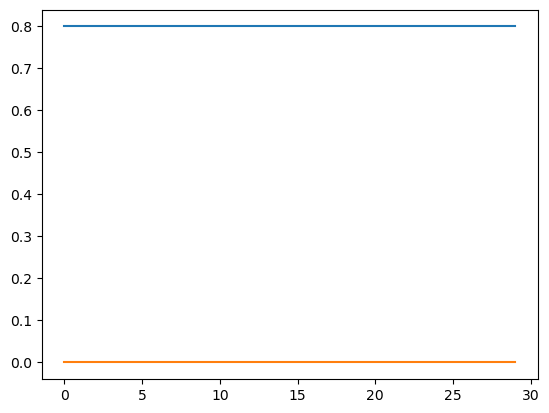

In [340]:
plt.plot(ref[1,:])
plt.plot(ref[3,:])

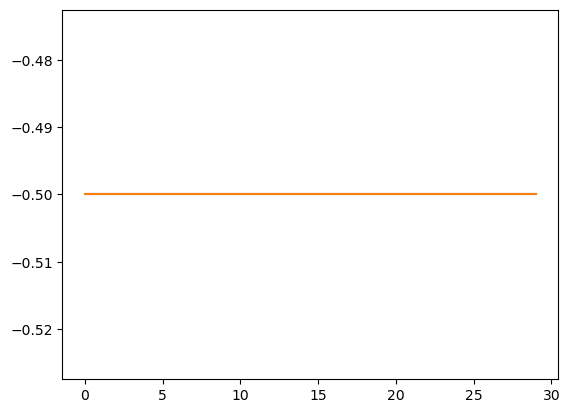

In [341]:
plt.plot(ref[0,:])
plt.plot(ref[2,:])

In [342]:
Q = jnp.diag(jnp.array([3, 1, 4, 1, 0.001, 0.001, 0.001, 0.001]))
R = jnp.diag(jnp.array([0.0001, 0.0001]))

def hopper_cost(x, u, x_ref, i): 
    x_error = x - x_ref[:,i]
    cost = jnp.dot(x_error, jnp.dot(Q,x_error)) + 0.3 * (jnp.linalg.norm(x[0:2] - x[2:4]) - 0.4) ** 2 + jnp.dot(u, jnp.dot(R,u))
    return cost

In [343]:
def step_wrapper_hopper(carry, action):
    obs = carry[0]
    h = carry[1]
    machine_state = carry[2]
    i = carry[3]
    phase_offset = carry[4]
    cycle_index = carry[5]
    
    next_obs, machine_state = hopper_dynamics(obs, action, h, machine_state)
    
    state = machine_state[0]
    internal_ticks = machine_state[3]
    #cycle_index, _, _, _ = get_phase_variable_jit(i, phase_offset)
    
    ref = get_reference(cycle_index, state)
    
    cost = hopper_cost(obs, action, ref, internal_ticks)
    i += 1
    carry = (next_obs, h, machine_state, i, phase_offset, cycle_index)
    output = (next_obs, cost)
    return carry, output

def load_rollout_jax_i(step_fn):
    def rollout_aux(obs, actions, h, machine_state, i, phase_offset, cycle_index):
        carry = (obs, h, machine_state, i, phase_offset, cycle_index)
        _, output = jax.lax.scan(f=step_fn, init=carry, xs=actions)
        return output
    func = jax.jit(jax.vmap(rollout_aux, in_axes=(None, 0, None, None, None, None, None)))
    return func

## MPPI

In [344]:
import numpy as np
from scipy.interpolate import CubicSpline

CONTACT_PHASES = np.array([1,0])

class MPPI:
    def __init__(self, env, params):
        # Hyper-parameters configuration
        self.temperature = params['temperature']
        self.horizon = params['horizon']
        self.n_samples = params['n_samples']
        self.noise_sigma = np.array(params['noise_sigma'])
        self.machine_state = np.array(params['machine_state'])
        self.phase_offset = params['phase_offset']
        self.last_state = None
        self.ticks = 0
        self.cycle_index = 0
        self.phase_time = 0
        self.subphase_time = 0
        self.s_phase = 1

        # Get env parameters
        self.env_name = params["env_name"]
        self.act_dim = 2
        self.act_max = [250,25]
        self.act_min = [-250, -25]
        
        # Rollouts
        self.h = params['h']
        self.sample_type = params['sample_type']
        self.n_knots = params['n_knots']
        self.random_generator = np.random.default_rng(params["seed"])
        
        self.rollout_jax = load_rollout_jax_i(step_wrapper_hopper)
            
        self.trajectory = None
        self.reset_planner()
    
    def update_ticks_variables(self):
        cycle_index, phase_time, subphase_time, s_phase_index = get_phase_variable_jit(self.ticks, self.phase_offset)
        print("Cycle: {}".format(cycle_index))
        self.cycle_index = cycle_index
        self.phase_time = phase_time
        self.subphase_time = subphase_time
        self.s_phase = CONTACT_PHASES[s_phase_index]
                
    def reset_planner(self):
        self.trajectory = np.zeros((self.horizon, self.act_dim))
        self.trajectory += np.array([M1*GRAVITY,0])
            
    def add_noise(self, size):
        return self.random_generator.normal(size=size) * self.noise_sigma
    
    def sample_delta_u(self):
        if self.sample_type == 'normal':
            size = (self.n_samples, self.horizon, self.act_dim)
            return self.add_noise(size)
        elif self.sample_type == 'cubic':
            indices = np.arange(self.n_knots)*self.horizon//self.n_knots
            size = (self.n_samples, self.n_knots, self.act_dim)
            knot_points = self.add_noise(size)
            cubic_spline = CubicSpline(indices, knot_points, axis=1)
            return cubic_spline(np.arange(self.horizon))
        
    def get_u(self, obs): 
        self.update_ticks_variables()
        self.last_state = obs
        delta_u = self.sample_delta_u()
        actions = self.trajectory + delta_u
        actions = np.clip(actions, self.act_min, self.act_max)
        print("Machine_State: {}".format(self.machine_state))
        _, costs = self.rollout_jax(obs, actions, 
                                    self.h, self.machine_state, 
                                    self.ticks, self.phase_offset, 
                                    self.cycle_index) 
          
        costs_sum = costs.sum(axis=1).squeeze() 
        # MPPI weights calculation
        ## Scale parameters
        min_cost = np.min(costs_sum)
        max_cost = np.max(costs_sum)
        
        exp_weights = np.exp(-1/self.temperature * ((costs_sum - min_cost)/(max_cost - min_cost)))
        weighted_delta_u = exp_weights.reshape(self.n_samples, 1, 1) * delta_u
        weighted_delta_u = np.sum(weighted_delta_u, axis=0) / (np.sum(exp_weights) + 1e-10)
        updated_actions = self.trajectory + weighted_delta_u
        updated_actions = np.clip(updated_actions, self.act_min, self.act_max)
    
        # Pop out first action from the trajectory and repeat last action
        self.trajectory = np.roll(updated_actions, shift=-1, axis=0)
        self.trajectory[-1] = updated_actions[-1]

        # Output first action (MPC)
        action = updated_actions[0] 
        return action, min_cost

In [345]:
# state {swing:0, stance:1, early:2, late:3}, s_hat {0,1}, s_phase {0,1}, internalt_ticks {int}
params = {'seed':42,
          'h':0.02,
          'env_name':'Hopper-opt',
          'sample_type':'cubic',
          #'sample_type':'normal',
          'n_knots':10,
          'horizon':50,
          'temperature':0.001,
          'n_samples':1000,
          'noise_sigma':[10.0, 0.8],
          'machine_state':[1, 1, 1, 0], #
          'phase_offset':0}

In [346]:
controller_jax = MPPI(None, params)
controller_jax.reset_planner()

In [347]:
controller_jax.env_name

'Hopper-opt'

In [348]:
1.3*9

11.700000000000001

In [349]:
ticks = 0
h = 0.02
tfinal = 11.7
tvec = np.linspace(0,tfinal,int(np.ceil(tfinal/h))+1)
machine_state = jnp.array(params["machine_state"])
x = q_ref[0]*1
q_sim = []  
costs_sim = []
u_sim = []

for ticks, ti in enumerate(tvec):
    controller_jax.ticks = ticks
    controller_jax.machine_state = machine_state 
    u, costs = controller_jax.get_u(x)
    x, machine_state = hopper_dynamics(x, u, h, machine_state)
    q_sim.append(x)
    u_sim.append(u)
    costs_sim.append(costs)

Cycle: 0
Machine_State: [1 1 1 0]
Guard function: Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=3/0)>
Guard function: 1
Cycle: 0
Machine_State: [1 1 1 1]
Guard function: 0
Cycle: 0
Machine_State: [1 1 1 2]
Guard function: 0
Cycle: 0
Machine_State: [1 1 1 3]
Guard function: 0
Cycle: 0
Machine_State: [1 1 1 4]
Guard function: 0
Cycle: 0
Machine_State: [1 1 1 5]
Guard function: 0
Cycle: 0
Machine_State: [1 1 1 6]
Guard function: 0
Cycle: 0
Machine_State: [1 1 1 7]
Guard function: 0
Cycle: 0
Machine_State: [1 1 1 8]
Guard function: 0
Cycle: 0
Machine_State: [1 1 1 9]
Guard function: 0
Cycle: 0
Machine_State: [ 1  1  1 10]
Guard function: 0
Cycle: 0
Machine_State: [ 1  1  1 11]
Guard function: 0
Cycle: 0
Machine_State: [ 1  1  1 12]
Guard function: 0
Cycle: 0
Machine_State: [ 1  1  1 13]
Guard function: 0
Cycle: 0
Machine_State: [ 1  1  1 14]
Guard function: 0
Cycle: 0
Machine_State: [ 1  1  1 15]
Guard function: 0
Cycle: 0
Machine_State: [ 1  1  1 16]
Guard funct

Guard function: 0
Cycle: 2
Machine_State: [ 1  1  1 26]
Guard function: 0
Cycle: 2
Machine_State: [ 1  1  1 27]
Guard function: 0
Cycle: 2
Machine_State: [ 1  1  1 28]
Guard function: 0
Cycle: 2
Machine_State: [ 1  1  1 29]
Guard function: 0
Cycle: 2
Machine_State: [ 1  1  1 30]
Guard function: 0
Cycle: 2
Machine_State: [ 1  1  1 31]
Guard function: 0
Cycle: 2
Machine_State: [ 1  1  1 32]
Guard function: 0
Cycle: 2
Machine_State: [ 1  1  1 33]
Guard function: 0
Cycle: 2
Machine_State: [ 1  1  1 34]
Guard function: 0
Cycle: 2
Machine_State: [ 1  1  1 35]
Guard function: 0
Cycle: 2
Machine_State: [ 1  1  1 36]
Guard function: 0
Cycle: 2
Machine_State: [ 1  1  1 37]
Guard function: 0
Cycle: 2
Machine_State: [ 1  1  1 38]
Guard function: 0
Cycle: 2
Machine_State: [ 1  1  1 39]
Guard function: 0
Cycle: 2
Machine_State: [ 1  1  1 40]
Guard function: 0
Cycle: 2
Machine_State: [ 1  1  1 41]
Guard function: 0
Cycle: 2
Machine_State: [ 1  1  1 42]
Guard function: 0
Cycle: 2
Machine_State: [ 1  1

Guard function: 0
Cycle: 4
Machine_State: [ 1  1  1 49]
Guard function: 0
Cycle: 4
Machine_State: [0 0 0 0]
Guard function: 0
Cycle: 4
Machine_State: [0 0 0 1]
Guard function: 0
Cycle: 4
Machine_State: [0 0 0 2]
Guard function: 0
Cycle: 4
Machine_State: [0 0 0 3]
Guard function: 0
Cycle: 4
Machine_State: [0 0 0 4]
Guard function: 0
Cycle: 4
Machine_State: [0 0 0 5]
Guard function: 0
Cycle: 4
Machine_State: [0 0 0 6]
Guard function: 0
Cycle: 4
Machine_State: [0 0 0 7]
Guard function: 0
Cycle: 4
Machine_State: [0 0 0 8]
Guard function: 0
Cycle: 4
Machine_State: [0 0 0 9]
Guard function: 1
Cycle: 4
Machine_State: [ 2  1  0 10]
Guard function: 0
Cycle: 4
Machine_State: [ 2  1  0 11]
Guard function: 0
Cycle: 4
Machine_State: [ 2  1  0 12]
Guard function: 0
Cycle: 4
Machine_State: [ 2  1  0 13]
Guard function: 0
Cycle: 4
Machine_State: [ 2  1  0 14]
Guard function: 0
Cycle: 5
Machine_State: [1 1 1 0]
Guard function: 0
Cycle: 5
Machine_State: [1 1 1 1]
Guard function: 0
Cycle: 5
Machine_State

Cycle: 7
Machine_State: [ 1  1  1 17]
Guard function: 0
Cycle: 7
Machine_State: [ 1  1  1 18]
Guard function: 0
Cycle: 7
Machine_State: [ 1  1  1 19]
Guard function: 0
Cycle: 7
Machine_State: [ 1  1  1 20]
Guard function: 0
Cycle: 7
Machine_State: [ 1  1  1 21]
Guard function: 0
Cycle: 7
Machine_State: [ 1  1  1 22]
Guard function: 0
Cycle: 7
Machine_State: [ 1  1  1 23]
Guard function: 0
Cycle: 7
Machine_State: [ 1  1  1 24]
Guard function: 0
Cycle: 7
Machine_State: [ 1  1  1 25]
Guard function: 0
Cycle: 7
Machine_State: [ 1  1  1 26]
Guard function: 0
Cycle: 7
Machine_State: [ 1  1  1 27]
Guard function: 0
Cycle: 7
Machine_State: [ 1  1  1 28]
Guard function: 0
Cycle: 7
Machine_State: [ 1  1  1 29]
Guard function: 0
Cycle: 7
Machine_State: [ 1  1  1 30]
Guard function: 0
Cycle: 7
Machine_State: [ 1  1  1 31]
Guard function: 0
Cycle: 7
Machine_State: [ 1  1  1 32]
Guard function: 0
Cycle: 7
Machine_State: [ 1  1  1 33]
Guard function: 0
Cycle: 7
Machine_State: [ 1  1  1 34]
Guard func

In [350]:
visualize_hopper(vis, q_sim, h)

In [351]:
u1 = [ui[0] for ui in u_sim]
u2 = [ui[1] for ui in u_sim]

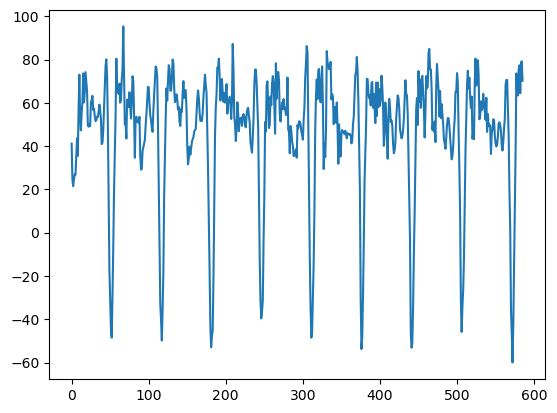

In [352]:
plt.plot(u1)

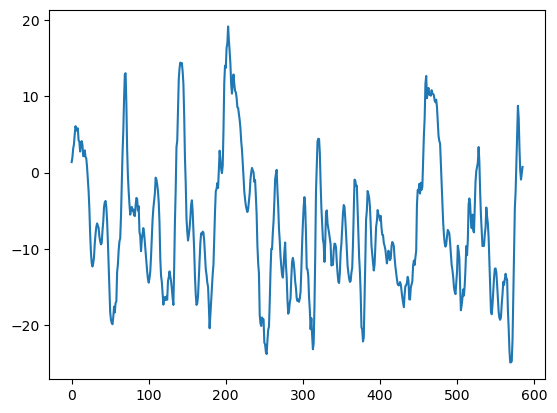

In [353]:
plt.plot(u2)

In [354]:
rfy = [qi[3] for qi in q_sim]

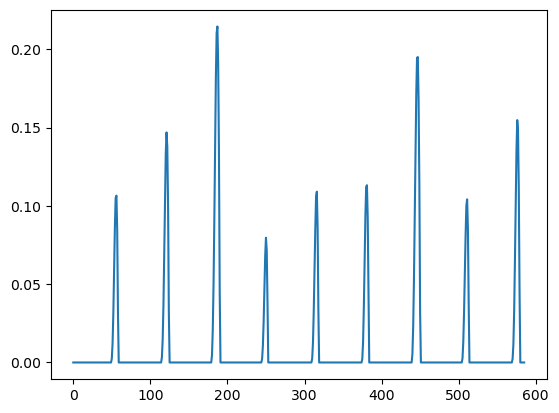

In [355]:
plt.plot(rfy)